<a href="https://colab.research.google.com/github/Janardan-thapaliya/Deep_Learning_CNN/blob/main/N_MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

# Ensure the Kaggle API key is in the correct location
os.makedirs("/root/.kaggle", exist_ok=True)
os.system("cp /content/kaggle.json /root/.kaggle/")
os.system("chmod 600 /root/.kaggle/kaggle.json")

# Download the dataset
os.system("kaggle datasets download -d khoahongg/n-mnist")


0

In [3]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 9.9 MB/s eta 0:00:00


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import zipfile
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#Extract the dataset
with zipfile.ZipFile('/content/n-mnist.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

# Function to read N-MNIST binary files
def read_nmnist_file(file_path):
    x_coords, y_coords, polarities, timestamps = [], [], [], []
    with open(file_path, 'rb') as f:
        data = f.read()
        for i in range(0, len(data), 5):
            event = int.from_bytes(data[i:i+5], byteorder='big')
            x_coords.append((event >> 32) & 0xFF)
            y_coords.append((event >> 24) & 0xFF)
            polarities.append((event >> 23) & 0x01)
            timestamps.append(event & 0x7FFFFF)
    return x_coords, y_coords, polarities, timestamps

# Convert events to a frame-based representation
def event_to_frame(x, y, p, t, img_size=(34, 34)):
    frame = np.zeros(img_size, dtype=np.float32)
    for x_, y_, p_, t_ in zip(x, y, p, t):
        frame[y_, x_] += 1 if p_ == 1 else -1
    return torch.tensor(frame).unsqueeze(0)  # Add channel dimension

# Custom dataset class
class NMNISTDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path, target = self.file_paths[idx]
        x, y, p, t = read_nmnist_file(file_path)
        frame = event_to_frame(x, y, p, t)
        return frame, target

# Get file paths and targets
def get_file_paths(root_dir):
    return [(os.path.join(root, file), int(os.path.basename(root)))
            for root, _, files in os.walk(root_dir) for file in files]

train_files = get_file_paths('/content/Train/Train')
test_files = get_file_paths('/content/Test/Test')
train_dataset = NMNISTDataset(train_files)
test_dataset = NMNISTDataset(test_files)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define optimized CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Adjusted based on new pooling layers
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model
net = CNN(num_classes=10)
optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Training loop with improvements
num_epochs = 30
for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    correct, total = 0, 0

    for data, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(data)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


Epoch 1, Loss: 0.8849, Accuracy: 70.57%
Epoch 2, Loss: 0.4816, Accuracy: 84.25%
Epoch 3, Loss: 0.3972, Accuracy: 87.00%
Epoch 4, Loss: 0.3540, Accuracy: 88.53%
Epoch 5, Loss: 0.3263, Accuracy: 89.50%
Epoch 6, Loss: 0.3019, Accuracy: 90.17%
Epoch 7, Loss: 0.2852, Accuracy: 90.68%
Epoch 8, Loss: 0.2718, Accuracy: 91.17%
Epoch 9, Loss: 0.2576, Accuracy: 91.73%
Epoch 10, Loss: 0.2455, Accuracy: 91.94%
Epoch 11, Loss: 0.2340, Accuracy: 92.29%
Epoch 12, Loss: 0.2238, Accuracy: 92.73%
Epoch 13, Loss: 0.2154, Accuracy: 92.84%
Epoch 14, Loss: 0.2071, Accuracy: 93.22%
Epoch 15, Loss: 0.1972, Accuracy: 93.47%
Epoch 16, Loss: 0.1907, Accuracy: 93.73%
Epoch 17, Loss: 0.1819, Accuracy: 93.98%
Epoch 18, Loss: 0.1749, Accuracy: 94.22%
Epoch 19, Loss: 0.1690, Accuracy: 94.38%
Epoch 20, Loss: 0.1604, Accuracy: 94.61%
Epoch 21, Loss: 0.1545, Accuracy: 94.94%
Epoch 22, Loss: 0.1449, Accuracy: 95.12%
Epoch 23, Loss: 0.1402, Accuracy: 95.25%
Epoch 24, Loss: 0.1354, Accuracy: 95.37%
Epoch 25, Loss: 0.1295, A

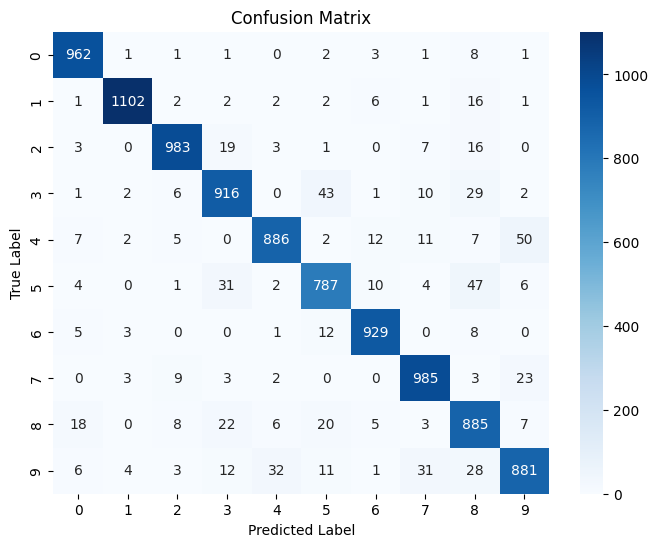

In [9]:
# Confusion Matrix Evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
net.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for data, targets in test_loader:
        outputs = net(data)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(targets.numpy())
        y_pred.extend(predicted.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
